# Repte 3

## Definició del problema

Es vol predir el consum de combustible de diferents models de cotxes dels anys 70. Per fer-ho disposem d'un *dataset* amb diferents aspectes tècnics dels diferents models i el seu consum. Aquestes són les dades que conté:


*   Miles per Gallon (mpg): *variable contínua*
*   cylinders: *variable discreta de valors múltiples*
*   displacement: *variable contínua*
*   horsepower: *variable contínua*
*   weight: *variable contínua*
*   acceleration: *variable contínua*
*   model year: *variable discreta de valors múltiples*
*   origin: *variable categòrica*

Aquest dataset es pot descarregar de [https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data)

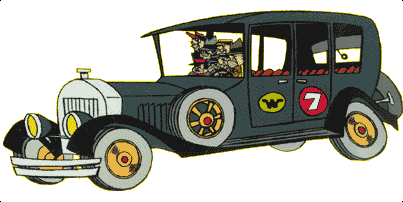

## Preparació de les dades

In [204]:
# Importa les llibreries que necessitaràs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


In [205]:
# Descarrega el dataset fent servir el packet urllib de Python i guarda-ho
# amb el nom auto-mpg.data
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', 'auto-mpg.data')

('auto-mpg.data', <http.client.HTTPMessage at 0x7fb2091b6700>)

In [206]:
# Importa el dataset descarregat com a csv, afegint els noms de les columnes i
# ajustant els paràmetres na_values, comment, sep, skipinitialspace, etc.
labels = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
auto_ds = pd.read_csv('auto-mpg.data', names=labels, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
# Mostra les últimes 5 fil·les
auto_ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [207]:
# Comprova si falta algun valor a tot el conjunt de dades
auto_ds.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [208]:
# No podem alimentar la xarxa neuronal amb cap valor de tipus Nan, Null o ? així
# que en cas de que es doni aquesta situació, eliminarem aquestes files per obtenir
# un dataset sense errors.
# Elimina les files afectades per aquests errors
auto_ds = auto_ds.dropna()

In [209]:
# La columna origin ens indica l'origen del vehicle on: 1-USA, 2-Europa, 3-Japan
# Aquesta és una variable categòrica que haurem de convertir a un vector booleà
# fent ús de la codificació one-hot encoding.
#
# Crea 3 noves columnes (USA, Europe, Japan) amb valor 1 o 0 en funció de la columna
# Origin. Pots fer servir el mètode pop() de Pandas
origin = auto_ds.pop('Origin')
auto_ds['USA'] = (origin == 1)*1.0
auto_ds['Europe'] = (origin == 2)*1.0
auto_ds['Japan'] = (origin == 3)*1.0

<ipython-input-209-db8611a5449c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_ds['USA'] = (origin == 1)*1.0
<ipython-input-209-db8611a5449c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_ds['Europe'] = (origin == 2)*1.0
<ipython-input-209-db8611a5449c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [210]:
# Separa les dades per tal d'obtenir un dataset_train amb el 80% de les mostres i
# un dataset_test amb el 20%. Pots fer servir la funció sample() de Pandas.
x_train = auto_ds.sample(frac=0.8)
x_test = auto_ds.drop(x_train.index)
y_train = x_train.pop('MPG')
y_test = x_test.pop('MPG')

In [211]:
# Mostra les principals característiques estadístiques per a cada columna i
# guarda-les a la variable train_stats de forma trasposada
train_stats = x_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.404459,1.676404,3.0,4.0,4.0,6.00,8.0
Displacement,314.0,191.635350,103.264858,70.0,105.0,151.0,258.00,455.0
Horsepower,314.0,103.035032,37.207844,46.0,76.0,92.0,115.75,230.0
Weight,314.0,2955.649682,839.927392,1613.0,2226.5,2750.0,3533.75,5140.0
Acceleration,314.0,15.640764,2.576744,9.0,14.0,15.5,17.00,24.6
Model Year,314.0,75.993631,3.704754,70.0,73.0,76.0,79.00,82.0
USA,314.0,0.627389,0.484272,0.0,0.0,1.0,1.00,1.0
Europe,314.0,0.168790,0.375164,0.0,0.0,0.0,0.00,1.0
Japan,314.0,0.203822,0.403481,0.0,0.0,0.0,0.00,1.0


### Pregunta 1
Observant les dades estadístiques, creus que és convenient normalitzar les dades? Raona la resposta.

Crec que és convenient normalitzar les dades ja que el model utilitza diferents escales i rangs, la qual cosa dificulta l'entrenament.

In [212]:
# Aquesta funció reescala les característiques en un rang de 0 a 1 (normalització)
# i les centra al 0 (estandarització) amb una desviació estàndard de 1

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# Aplica la funció anterior a les dades d'entrenament i de prova
x_train = norm(x_train)
x_test = norm(x_test)

In [213]:
# Comprova la normalització revisant les estadístiques de les dades
print(x_train.describe())
print(x_test.describe())

          Cylinders  Displacement    Horsepower        Weight  Acceleration  \
count  3.140000e+02  3.140000e+02  3.140000e+02  3.140000e+02  3.140000e+02   
mean  -1.018294e-16  1.060723e-16  1.626441e-16  1.159723e-16 -1.250238e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.434295e+00 -1.177897e+00 -1.532877e+00 -1.598531e+00 -2.577192e+00   
25%   -8.377803e-01 -8.389626e-01 -7.265949e-01 -8.681104e-01 -6.367587e-01   
50%   -8.377803e-01 -3.935061e-01 -2.965781e-01 -2.448422e-01 -5.462876e-02   
75%    3.552493e-01  6.426644e-01  3.417282e-01  6.882742e-01  5.275012e-01   
max    1.548279e+00  2.550380e+00  3.412317e+00  2.600642e+00  3.476960e+00   

         Model Year           USA        Europe         Japan  
count  3.140000e+02  3.140000e+02  3.140000e+02  3.140000e+02  
mean  -6.406765e-16  9.617219e-17  6.505765e-17  7.354344e-17  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
min   -1.617822e+00 -1.295530e+0

### Pregunta 2
Com podem saber que hem realitzat bé la normalització a partir de la informació estadística?

Perquè la mitja és propera al 0 i la desviació es propera al 1

## Definició del model
### Pregunta 3
Quin tipus de problema és? Regressió, classificació binària o classificació múltiple? Raona la resposta

És un problema de Regressió, ja que busquem predir la sortida d'un valor continu com a probabilitat.

### Pregunta 4
Quàntes neurones i amb quina funció d'activació haurà de tenir la capa de sortida? Raona la resposta.

In [214]:
# Crea un model de xarxa neuronal de tipus Dense amb 2 capes de 64 neurones amb
# funció d'activació 'relu' i una capa de sortida
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=[len(x_train.keys())]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [215]:
# Configura i executa l'entrenament del model. Hauràs d'escollir la funció de pèrdua
# adient en funció del tipus de problema a resoldre (Pregunta 3).
# Farem servir les mètriques 'root mean square error' i 'mean absolute error'.
# Afegeix l'hiperparàmetre validation_split=0.2 a la funció fit()
# MAE és més robusta quan tenim valors atípics ja que no fa servir el quadrat de
# l'error mentre que MSE és més útil si volem donar més importància als errors grans.

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
model.summary()
model.fit(x_train, y_train, epochs=50, validation_split=0.2)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                640       
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
8/8 [==============================] - 1s 23ms/step - loss: 593.6121 - mae: 23.1333 - mse: 593.6121 - val_loss: 544.0790 - val_mae: 22.0770 - val_mse: 544.0790
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 566.1607 - mae: 22.5018 - mse: 566.1607 - val_loss: 515.6432 - val_mae: 21

In [216]:
# Fes una evaluació del model amb les dades de test
loss, mae, mse = model.evaluate(x_test, y_test)
print('root mean square error:', mse, 'mean absolute error:', mae)

3/3 [==============================] - 0s 4ms/step - loss: 12.7275 - mae: 2.6150 - mse: 12.7275
root mean square error: 12.727462768554688 mean absolute error: 2.615022659301758


### Pregunta 5
Quin significat tenen els números obtinguts a **mae** i **mse**? Diríes que és un error acceptable? Per què?

El significat dels números obtinguts a mae i mse és que el model té un error en la seva predicció. Aquest error és acceptable ja que és un error petit en comparació amb el rang de valors que podem trobar a la columna MPG del dataset

## Predicció

In [217]:
# Realitza la predicció d'un suposat cotxe amb:
#   4 cilindres
#   Desplaçament 100
#   50 C.V.
#   1500 kg
#   Acceleració 10 m/s^2
#   Any 82
#   Europeu
cotxe = norm([4, 100, 50, 1500, 10, 82, 0, 1, 0]).to_frame('mean').transpose()
prediccio = model.predict(cotxe)
print('Prediccio MPG:', prediccio)

1/1 [==============================] - 0s 45ms/step
Prediccio MPG: [[44.661465]]
